# Student Name: Saeedreza Zouashkiani
# Student ID: 400206262

In [1]:
# Load necessary libraries and load device
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch 
import matplotlib.pyplot as plt
import string
from torchvision import transforms
from torch import optim
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

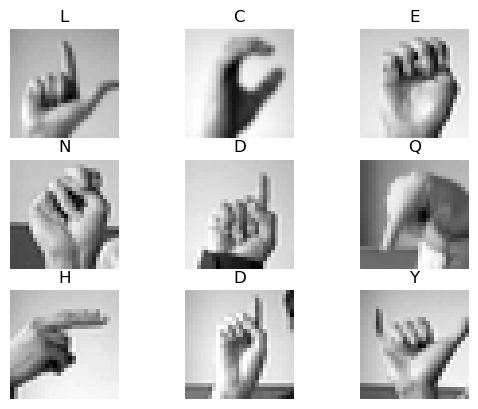

In [2]:
# Load alphabet into a list and create a dictionary to map each letter to a number
alphabet = list(string.ascii_uppercase)[:25]
num2letter = {num: letter for num, letter in enumerate(alphabet)}
# Load q3_train.csv and plot 9 random images with their labels
df = pd.read_csv('./DL_HW2/Data/HW2_data/Q3_train.csv')
df = df.sample(frac=1)
df = df.reset_index(drop=True)
df = df[:9]
df = df.reset_index(drop=True)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(df.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    plt.title(num2letter[df.iloc[i, 0]])
    plt.axis('off')
plt.show()


In [3]:
# create a custom dataset class to load the data from q3_train.csv and q3_test.csv
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.data.iloc[idx, 1:].values.astype('float32')
        y = self.data.iloc[idx, 0]
        if self.transform:
            x = self.transform(x)
        return x, y

# create a custom transform class to normalize the data
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        return (sample - self.mean) / self.std     

In [4]:
# define a transform to normalize the data
transform = transforms.Compose([Normalize(0.5, 0.5)])

# Load q3_train.csv and shuffle the data and split it into train and validation sets
trainset = CustomDataset('./DL_HW2/Data/HW2_data/Q3_train.csv', transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [int(0.8*len(trainset)), int(0.2*len(trainset))],
generator=torch.Generator().manual_seed(42))
testset = CustomDataset('./DL_HW2/Data/HW2_data/Q3_test.csv', transform=transform)
# create dataloaders for train and validation and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [5]:
# define an MLP model with 2 hidden layers
# there are 25 classes in the dataset

class MLP(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# define a function to train the model and return the training and validation losses and accuracies
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(1) == y).type(torch.float).mean().item()
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item()
                val_acc += (output.argmax(1) == y).type(torch.float).mean().item()
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_accs.append(train_acc/len(train_loader))
        val_accs.append(val_acc/len(val_loader))
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss/len(train_loader), val_loss/len(val_loader), train_acc/len(train_loader), val_acc/len(val_loader)))
    return train_losses, val_losses, train_accs, val_accs

In [7]:
# define a function to test the model and return the test loss and accuracy
def test_model(model, test_loader, criterion):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y)
            test_loss += loss.item()
            test_acc += (output.argmax(1) == y).type(torch.float).mean().item()
    print('Test Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(test_loss/len(test_loader), test_acc/len(test_loader)))
    return test_loss/len(test_loader), test_acc/len(test_loader)

In [8]:
# define the loss function
criterion = nn.CrossEntropyLoss()

In [9]:
# Choose the best learning rate for Adam optimizer
learning_rates = [1e-5, 3e-5,1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for lr in learning_rates:
    model = MLP(784, 256, 25).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=4)
    train_losses.append(train_loss[3])
    val_losses.append(val_loss[3])
    train_accs.append(train_acc[3])
    val_accs.append(val_acc[3])

# choose the best learning rate
best_lr_Adam = learning_rates[np.argmax(val_accs)]
print('Best learning rate: {}'.format(best_lr_Adam))

Epoch: 1 	Training Loss: 10.276465 	Validation Loss: 4.661167 	Training Accuracy: 0.124803 	Validation Accuracy: 0.214813
Epoch: 2 	Training Loss: 3.654871 	Validation Loss: 3.012518 	Training Accuracy: 0.286004 	Validation Accuracy: 0.356165
Epoch: 3 	Training Loss: 2.546756 	Validation Loss: 2.252546 	Training Accuracy: 0.409339 	Validation Accuracy: 0.455740
Epoch: 4 	Training Loss: 1.937244 	Validation Loss: 1.770793 	Training Accuracy: 0.507373 	Validation Accuracy: 0.545354
Epoch: 1 	Training Loss: 7.420728 	Validation Loss: 3.053841 	Training Accuracy: 0.190589 	Validation Accuracy: 0.353757
Epoch: 2 	Training Loss: 2.258218 	Validation Loss: 1.681612 	Training Accuracy: 0.460726 	Validation Accuracy: 0.553719
Epoch: 3 	Training Loss: 1.315576 	Validation Loss: 0.994492 	Training Accuracy: 0.629830 	Validation Accuracy: 0.700567
Epoch: 4 	Training Loss: 0.829912 	Validation Loss: 0.747737 	Training Accuracy: 0.747411 	Validation Accuracy: 0.765611
Epoch: 1 	Training Loss: 4.1707

In [10]:
# choose best learning rate for SGD optimizer
learning_rates = [1e-5, 3e-5,1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for lr in learning_rates:
    model = MLP(784, 256, 25).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=4)
    train_losses.append(train_loss[3])
    val_losses.append(val_loss[3])
    train_accs.append(train_acc[3])
    val_accs.append(val_acc[3])
# choose the best learning rate
best_lr_SGD = learning_rates[np.argmax(val_accs)]
print('Best learning rate: {}'.format(best_lr_SGD))

Epoch: 1 	Training Loss: 9.123643 	Validation Loss: 6.085004 	Training Accuracy: 0.124667 	Validation Accuracy: 0.159257
Epoch: 2 	Training Loss: 4.483299 	Validation Loss: 4.215172 	Training Accuracy: 0.240461 	Validation Accuracy: 0.257189
Epoch: 3 	Training Loss: 3.477134 	Validation Loss: 3.372546 	Training Accuracy: 0.313908 	Validation Accuracy: 0.319963
Epoch: 4 	Training Loss: 2.916653 	Validation Loss: 3.325338 	Training Accuracy: 0.360511 	Validation Accuracy: 0.356799
Epoch: 1 	Training Loss: 6.130866 	Validation Loss: 6.475069 	Training Accuracy: 0.188469 	Validation Accuracy: 0.164251
Epoch: 2 	Training Loss: 2.767436 	Validation Loss: 2.967554 	Training Accuracy: 0.365552 	Validation Accuracy: 0.348623
Epoch: 3 	Training Loss: 1.973349 	Validation Loss: 2.023364 	Training Accuracy: 0.484420 	Validation Accuracy: 0.468729
Epoch: 4 	Training Loss: 1.549838 	Validation Loss: 2.366339 	Training Accuracy: 0.570646 	Validation Accuracy: 0.457913
Epoch: 1 	Training Loss: 4.03611

In [11]:
# define the model save the best model based on the validation accuracy
model_Adam = MLP(784, 256, 25).to(device)
optimizer = optim.Adam(model_Adam.parameters(), lr=best_lr_Adam)
train_losses_Adam, val_losses_Adam, train_accs_Adam, val_accs_Adam = train_model(model_Adam, train_loader, val_loader, criterion, optimizer, epochs=50)
test_loss_Adam, test_acc_Adam = test_model(model_Adam, test_loader, criterion)
torch.save(model_Adam.state_dict(), './model_Adam.pt')

Epoch: 1 	Training Loss: 4.645206 	Validation Loss: 1.771584 	Training Accuracy: 0.316800 	Validation Accuracy: 0.504286
Epoch: 2 	Training Loss: 1.229427 	Validation Loss: 1.168385 	Training Accuracy: 0.624061 	Validation Accuracy: 0.617939
Epoch: 3 	Training Loss: 0.753604 	Validation Loss: 0.572873 	Training Accuracy: 0.754800 	Validation Accuracy: 0.810220
Epoch: 4 	Training Loss: 0.457829 	Validation Loss: 0.307935 	Training Accuracy: 0.851199 	Validation Accuracy: 0.895206
Epoch: 5 	Training Loss: 0.304434 	Validation Loss: 0.232524 	Training Accuracy: 0.899936 	Validation Accuracy: 0.917101
Epoch: 6 	Training Loss: 0.206626 	Validation Loss: 0.148938 	Training Accuracy: 0.933957 	Validation Accuracy: 0.948989
Epoch: 7 	Training Loss: 0.196179 	Validation Loss: 0.200010 	Training Accuracy: 0.934775 	Validation Accuracy: 0.930956
Epoch: 8 	Training Loss: 0.131642 	Validation Loss: 0.052880 	Training Accuracy: 0.958485 	Validation Accuracy: 0.989644
Epoch: 9 	Training Loss: 0.27561

In [12]:
# define the model and save the best model based on the validation accuracy
model_SGD = MLP(784, 256, 25).to(device)
optimizer = optim.SGD(model_SGD.parameters(), lr=best_lr_SGD)
train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD = train_model(model_SGD, train_loader, val_loader, criterion, optimizer, epochs=50)
test_loss_SGD, test_acc_SGD = test_model(model_SGD, test_loader, criterion)
torch.save(model_SGD.state_dict(), './model_SGD.pt')

Epoch: 1 	Training Loss: 4.881738 	Validation Loss: 3.927450 	Training Accuracy: 0.252089 	Validation Accuracy: 0.180877
Epoch: 2 	Training Loss: 1.658633 	Validation Loss: 1.758490 	Training Accuracy: 0.497396 	Validation Accuracy: 0.456506
Epoch: 3 	Training Loss: 1.233721 	Validation Loss: 1.210786 	Training Accuracy: 0.616930 	Validation Accuracy: 0.626981
Epoch: 4 	Training Loss: 0.983257 	Validation Loss: 1.162440 	Training Accuracy: 0.701187 	Validation Accuracy: 0.625933
Epoch: 5 	Training Loss: 0.804795 	Validation Loss: 1.089797 	Training Accuracy: 0.755723 	Validation Accuracy: 0.660461
Epoch: 6 	Training Loss: 0.671765 	Validation Loss: 0.848888 	Training Accuracy: 0.806459 	Validation Accuracy: 0.719644
Epoch: 7 	Training Loss: 0.570409 	Validation Loss: 0.562344 	Training Accuracy: 0.842387 	Validation Accuracy: 0.835838
Epoch: 8 	Training Loss: 0.479589 	Validation Loss: 0.491621 	Training Accuracy: 0.872138 	Validation Accuracy: 0.852464
Epoch: 9 	Training Loss: 0.41503

In [17]:
# define a new model like MLP but with dropout
class MLP_dropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_dropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [18]:
# choose best learning rate for Adam optimizer for MLP_dropout
learning_rates = [1e-5, 3e-5,1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for lr in learning_rates:
    model = MLP_dropout(784, 256, 25).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=4)
    train_losses.append(train_loss[3])
    val_losses.append(val_loss[3])
    train_accs.append(train_acc[3])
    val_accs.append(val_acc[3])
# choose the best learning rate
best_lr_Adam_dropout = learning_rates[np.argmax(val_accs)]
print('Best learning rate: {}'.format(best_lr_Adam_dropout))

Epoch: 1 	Training Loss: 21.745455 	Validation Loss: 3.931410 	Training Accuracy: 0.060471 	Validation Accuracy: 0.126913
Epoch: 2 	Training Loss: 3.803217 	Validation Loss: 2.918054 	Training Accuracy: 0.100170 	Validation Accuracy: 0.169296
Epoch: 3 	Training Loss: 3.053667 	Validation Loss: 2.728025 	Training Accuracy: 0.139944 	Validation Accuracy: 0.227250
Epoch: 4 	Training Loss: 2.876738 	Validation Loss: 2.565883 	Training Accuracy: 0.182534 	Validation Accuracy: 0.279362
Epoch: 1 	Training Loss: 8.240438 	Validation Loss: 2.817813 	Training Accuracy: 0.088966 	Validation Accuracy: 0.184422
Epoch: 2 	Training Loss: 2.869562 	Validation Loss: 2.337137 	Training Accuracy: 0.174146 	Validation Accuracy: 0.322147
Epoch: 3 	Training Loss: 2.517673 	Validation Loss: 1.928233 	Training Accuracy: 0.263566 	Validation Accuracy: 0.446420
Epoch: 4 	Training Loss: 2.197131 	Validation Loss: 1.593696 	Training Accuracy: 0.345249 	Validation Accuracy: 0.554709
Epoch: 1 	Training Loss: 4.9538

In [19]:
#  train the model with the best learning rate and save the best model based on the validation accuracy
model_Adam_dropout = MLP_dropout(784, 256, 25).to(device)
optimizer = optim.Adam(model_Adam_dropout.parameters(), lr=best_lr_Adam_dropout)
train_losses_Adam_dropout, val_losses_Adam_dropout, train_accs_Adam_dropout, val_accs_Adam_dropout = train_model(model_Adam_dropout, train_loader, val_loader, criterion, optimizer, epochs=80)
test_loss_Adam_dropout, test_acc_Adam_dropout = test_model(model_Adam_dropout, test_loader, criterion)
torch.save(model_Adam_dropout.state_dict(), './model_Adam_dropout.pt')


Epoch: 1 	Training Loss: 9.963744 	Validation Loss: 2.906082 	Training Accuracy: 0.082576 	Validation Accuracy: 0.171205
Epoch: 2 	Training Loss: 2.888407 	Validation Loss: 2.476668 	Training Accuracy: 0.170316 	Validation Accuracy: 0.306333
Epoch: 3 	Training Loss: 2.548195 	Validation Loss: 2.066600 	Training Accuracy: 0.259448 	Validation Accuracy: 0.393546
Epoch: 4 	Training Loss: 2.252098 	Validation Loss: 1.750883 	Training Accuracy: 0.329700 	Validation Accuracy: 0.485807
Epoch: 5 	Training Loss: 2.011013 	Validation Loss: 1.451724 	Training Accuracy: 0.392366 	Validation Accuracy: 0.556846
Epoch: 6 	Training Loss: 1.808931 	Validation Loss: 1.258571 	Training Accuracy: 0.443798 	Validation Accuracy: 0.627700
Epoch: 7 	Training Loss: 1.619085 	Validation Loss: 1.107887 	Training Accuracy: 0.496275 	Validation Accuracy: 0.686488
Epoch: 8 	Training Loss: 1.460565 	Validation Loss: 0.944408 	Training Accuracy: 0.535777 	Validation Accuracy: 0.736406
Epoch: 9 	Training Loss: 1.33622

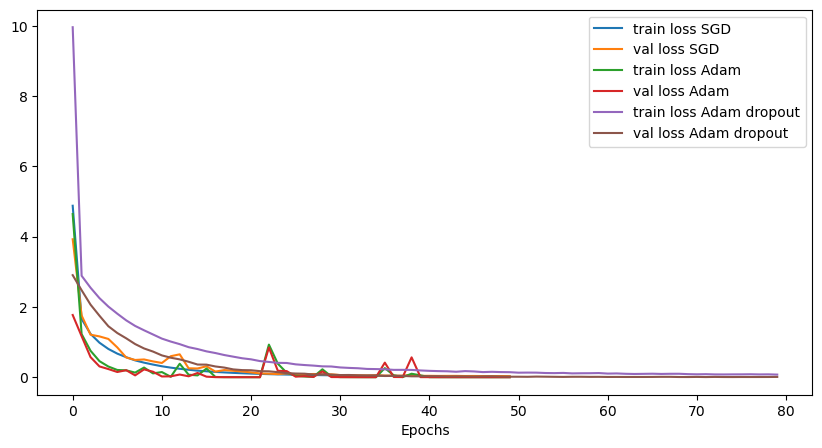

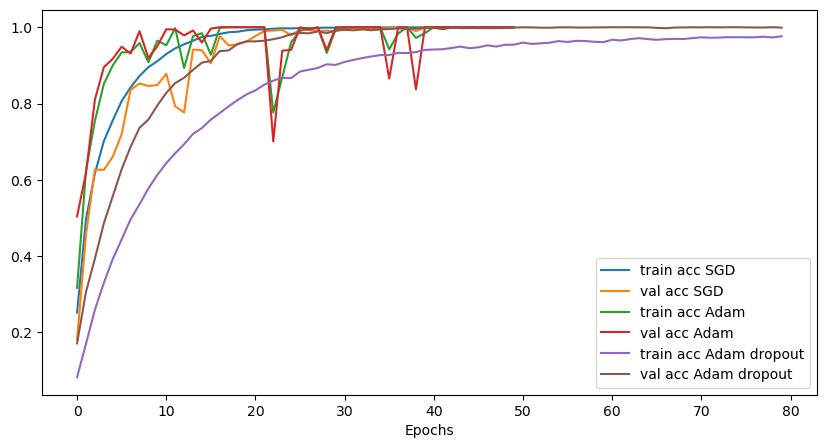

In [20]:
# plot the training and validation loss curves for MLP_SGD, MLP_Adam, MLP_Adam_dropout
plt.figure(figsize=(10, 5))
plt.plot(train_losses_SGD, label='train loss SGD')
plt.plot(val_losses_SGD, label='val loss SGD')
plt.plot(train_losses_Adam, label='train loss Adam')
plt.plot(val_losses_Adam, label='val loss Adam')
plt.plot(train_losses_Adam_dropout, label='train loss Adam dropout')
plt.plot(val_losses_Adam_dropout, label='val loss Adam dropout')
plt.legend()
plt.xlabel('Epochs')
plt.show()

# plot the training and validation accuracy curves for MLP_SGD, MLP_Adam, MLP_Adam_dropout
plt.figure(figsize=(10, 5))
plt.plot(train_accs_SGD, label='train acc SGD')
plt.plot(val_accs_SGD, label='val acc SGD')
plt.plot(train_accs_Adam, label='train acc Adam')
plt.plot(val_accs_Adam, label='val acc Adam')
plt.plot(train_accs_Adam_dropout, label='train acc Adam dropout')
plt.plot(val_accs_Adam_dropout, label='val acc Adam dropout')
plt.legend()
plt.xlabel('Epochs')
plt.show()
